In [333]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score
from matplotlib import pyplot as plt
from tqdm import tqdm



In [409]:
np.random.seed(200)

Base class

In [310]:
class baseModel:
    def forward(self, x):
        pass

    def backward(self, output, learning_rate):
        pass

### Convolution: There will be four (hyper)parameters:
1. Number of output channels
2. Filter dimension
3. Stride
4. Padding

### Important Links
#### Backward
1. [conv backward dx](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710)
2. [conv backward dw, db](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-fb2f2efc4faa)
3. [conv implement](https://github.com/slvrfn/vectorized_convolution/blob/master/convolution.py?fbclid=IwAR1SFj7zg2banabtjIWb9Rjrww1rjuGX4CZ7u8UHGIH3BJHnaSkMnhx2jdU)

In [311]:
class ConvolutionLayer(baseModel):
    def __init__(self, output_channel, kernel_size, stride, padding):
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = None
        self.bias = None
        self.x = None
        self.window_arr = None

    def forward(self, x):
        self.x = x # batch_size, channel, height, width
        batch_size, channel, height, width = x.shape
        output_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        self.output = np.zeros((batch_size, self.output_channel,  output_height, output_width))
        if self.weights is None:
            # init weight with Xavier method
            self.weights = np.random.randn(self.output_channel, channel, self.kernel_size, self.kernel_size) * np.sqrt(2 / (channel * self.kernel_size * self.kernel_size))
            self.bias = np.random.randn(self.output_channel)
        
        window_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.kernel_size, self.kernel_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2]*self.stride, x.strides[3]*self.stride, x.strides[2], x.strides[3]))

        self.window_arr = window_arr
        self.output = np.einsum('bihwkl,oikl->bohw', window_arr, self.weights) + self.bias[None, :, None, None]
        return self.output


    # backward prop vectorized
    def backward(self, output, learning_rate):
        
        x = self.x
        window_arr = self.window_arr
        dilate = self.stride - 1
        padding = self.kernel_size - 1 if self.padding == 0 else self.padding
        working_input = output

        # dilate the input if necessary
        if dilate != 0:
            working_input = np.insert(working_input, range(1, output.shape[2]), 0, axis=2)
            working_input = np.insert(working_input, range(1, output.shape[3]), 0, axis=3)

        # pad the input if necessary
        if self.padding != 0:
            working_input = np.pad(working_input, pad_width=((0,), (0,), (padding,), (padding,)), mode='constant', constant_values=(0.,))

        in_batch, in_channel, out_height, out_width = x.shape
        out_batch, out_channel, _, _ = output.shape
        batch_str, channel_str, kern_h_str, kern_w_str = working_input.strides
        stride = 1

        window_arr_out = np.lib.stride_tricks.as_strided(
        working_input,
        (out_batch, out_channel, out_height, out_width, self.kernel_size, self.kernel_size),
        (batch_str, channel_str, stride*kern_h_str, stride*kern_w_str, kern_h_str, kern_w_str))

        rotated_kernel = np.rot90(self.weights, 2, axes=(2, 3))

        db = np.sum(output, axis=(0, 2, 3))
        dw = np.einsum('bihwkl,bohw->oikl', window_arr, output)
        dx = np.einsum('bohwkl,oikl->bihw', window_arr_out, rotated_kernel)

        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db

        return dx
        

        
        

In [312]:
count = 1*1*5*5
input_arr = np.arange(-count/2, count/2).reshape(1, 1, 5, 5)
print(f'input: {input_arr}\n')
conv_layer = ConvolutionLayer(1, 3, 1, 0)
print(conv_layer)
output = conv_layer.forward(input_arr)
print(output.shape)
print(f'output--------\n{output}\n')

input: [[[[-12.5 -11.5 -10.5  -9.5  -8.5]
   [ -7.5  -6.5  -5.5  -4.5  -3.5]
   [ -2.5  -1.5  -0.5   0.5   1.5]
   [  2.5   3.5   4.5   5.5   6.5]
   [  7.5   8.5   9.5  10.5  11.5]]]]

(1, 1, 3, 3)
output--------
[[[[ 15.67624339  13.37258777  11.06893214]
   [  4.15796527   1.85430965  -0.44934598]
   [ -7.36031285  -9.66396847 -11.9676241 ]]]]



### ReLU: 

In [313]:
class ReLULayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, output, learning_rate):
        self.output = output
        return self.output * (self.x > 0)
        

In [314]:
relu_layer = ReLULayer()
output = relu_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 1, 3, 3)
output--------
[[[[15.67624339 13.37258777 11.06893214]
   [ 4.15796527  1.85430965  0.        ]
   [ 0.          0.          0.        ]]]]



### MaxPooling: There will be two parameters:
1. Filter dimension
2. Stride

### Important Links
#### Backward
1. [Maxpool Backward](https://stackoverflow.com/questions/61954727/max-pooling-backpropagation-using-numpy?fbclid=IwAR2PkO13F1_Jy99n5fysZD_dvHvqYQTPqno8Z-CLVt2-P664zjU1omJxMsQ)

In [315]:
class MaxPoolingLayer(baseModel):
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        self.output = np.zeros((batch_size, channel, output_height, output_width))
        
        # maxpooling without loop
        new_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.pool_size, self.pool_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2] * self.stride, x.strides[3] * self.stride, x.strides[2], x.strides[3]))
        self.output = np.max(new_arr, axis=(4, 5))
        return self.output

    def backward(self, output, learning_rate):
        x = self.x
        batch_size, channel, height, width = x.shape
        out_batch, out_channel, out_height, out_width = output.shape

        dx = np.zeros(shape=x.shape)

        for i in range(batch_size):
            for j in range(channel):
                for k in range(out_height):
                    for l in range(out_width):
                        # get the index in the region i,j where the value is the maximum
                        i_t, j_t = np.where(np.max(x[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size]) == x[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size])
                        i_t, j_t = i_t[0], j_t[0]
                        # print(i_t, j_t)
                        # only the position of the maximum element in the region i,j gets the incoming gradient, the other gradients are zero
                        dx[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size][i_t, j_t] = output[i, j, k, l]
        return dx
        

In [316]:
maxpool_layer = MaxPoolingLayer(2, 1)   
output = maxpool_layer.forward(output)

print(output.shape)
print(f'output--------\n{output}\n')

output_rev = maxpool_layer.backward(output, 0.1)
print(output_rev.shape)
print(f'output--------\n{output_rev}\n')

(1, 1, 2, 2)
output--------
[[[[15.67624339 13.37258777]
   [ 4.15796527  1.85430965]]]]

(1, 1, 3, 3)
output--------
[[[[15.67624339 13.37258777  0.        ]
   [ 4.15796527  1.85430965  0.        ]
   [ 0.          0.          0.        ]]]]



### Flattening: 

In [317]:
class FlatteningLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        self.output = x.reshape((batch_size, channel * height * width))
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        
        dx = self.output.reshape(self.x.shape)
        return dx

In [318]:
flat_layer = FlatteningLayer()
output = flat_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 4)
output--------
[[15.67624339 13.37258777  4.15796527  1.85430965]]



### Fully-connected layer: a dense layer. There will be one paramete:
1. Output dimension

In [319]:
class FullyConnectedLayer(baseModel):
    def __init__(self, output_channel):
        self.output_channel = output_channel
        self.weights = None
        self.bias = None

    def forward(self, x):
        self.x = x
        if self.weights is None:
            self.weights = np.random.randn(self.x.shape[1], self.output_channel) * np.sqrt(2 / self.x.shape[1])
            self.bias = np.random.randn(self.output_channel)
            
        self.output = np.dot(self.x, self.weights) + self.bias
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate

        dx = np.dot(self.output, self.weights.T)
        dw = np.dot(self.x.T, self.output)
        db = np.sum(self.output, axis=0)

        self.weights -= self.learning_rate * dw 
        self.bias -= self.learning_rate * db
        
        return dx

In [320]:
fullConn_layer = FullyConnectedLayer(10)
output = fullConn_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[-12.27200316   2.73852758 -17.56907209  32.94222365  -0.55384001
   -9.99676855  -3.3493249    3.81405259 -12.45593105  -7.59489822]]



### Softmax: it will convert final layer projections to normalized probabilities

In [321]:
class SoftmaxLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        # normalize input
        x -= np.max(x, axis=1, keepdims=True)
        self.output = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        return self.output

    def backward(self, output, learning_rate):
        return output

In [322]:
softmax_layer = SoftmaxLayer()
output = softmax_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[2.31052565e-20 7.63310899e-14 1.15670599e-22 1.00000000e+00
  2.83690235e-15 2.24818802e-19 1.73292881e-16 2.23767001e-13
  1.92234761e-20 2.48285673e-18]]



### Create Model

In [323]:
def createModel():
    model = []
    
    model.append(ConvolutionLayer(6, 5, 1, 0))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(ConvolutionLayer(16, 5, 1, 0))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(FlatteningLayer())
    model.append(FullyConnectedLayer(120))
    model.append(ReLULayer())
    model.append(FullyConnectedLayer(84))
    model.append(ReLULayer())
    model.append(FullyConnectedLayer(10))
    model.append(SoftmaxLayer())
    print('model created: ', model)
    return model

In [410]:
# get images
def getImages(path):
    images = []
    count = 0
    path_split = path.split('.')
    new_path = path_split[0]
    df = pd.read_csv(path)
    files = df['filename']
    for file in files:
        if count == 500:
            break
        img = cv2.imread(os.path.join(new_path, file))
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (255-img.transpose(2, 0, 1))/255
        images.append(img)
        count += 1

    return np.array(images)

In [411]:
# get labels
def getLabels(path):
    labels = []
    # using panda
    count = 500
    df = pd.read_csv(path)
    labels = df['digit'][:count]
    return np.array(labels)

In [334]:
# train
def train(model, X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    batch_size = 32
    for epoch in range(epochs):
        print(f'epoch: {epoch+1}/{epochs}')
        num_batches = X_train.shape[0] // batch_size
        loss = 0
        accuracy = 0
        for i in tqdm(range(num_batches)):
            # forward
            x_batch = X_train[i*batch_size: (i+1)*batch_size]
            y_output = Y_train[i*batch_size: (i+1)*batch_size]

            x_output = x_batch
            for layer in model:
                x_output = layer.forward(x_output)
            
            #loss
            loss += log_loss(y_output, x_output)
            accuracy += accuracy_score(np.argmax(y_output, axis=1), np.argmax(x_output, axis=1))

            dL = np.copy(x_output)
            dL -= y_output
            dL /= batch_size
            # backward
            for layer in reversed(model):
                dL = layer.backward(dL, learning_rate)
        
        # test
        val_loss = 0
        
        x_out = X_test
        for layer in model:
            x_out = layer.forward(x_out)

        # print(f'loss: {loss/num_batches}, val_loss: {val_loss}')
        val_loss = log_loss(Y_test, x_out)
        val_accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1))
        val_F1 = f1_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1), average='macro')
        print(f'loss: {loss/num_batches}, val_loss: {val_loss}')
        print(f'accuracy: {accuracy/num_batches}, val_accuracy: {val_accuracy}')
        print(f'val_F1: {val_F1}')

        
        



(500, 3, 28, 28)
(500, 10)
[0 0 0 1 0 0 0 0 0 0]


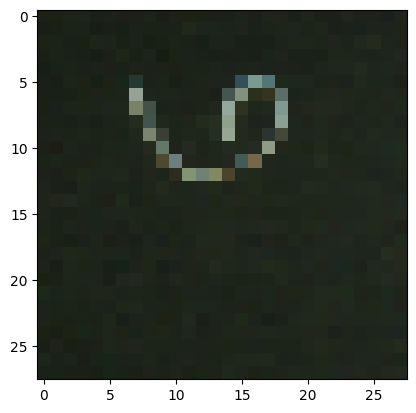

In [412]:
images = getImages('data/training-a.csv')
labels = getLabels('data/training-a.csv')
# # images.append(image)
# # labels.append(label)
# image += getImages('data/training-b')
# label += getLabels('data/training-b.csv')
# # images.append(image)
# # labels.append(label)


# one hot encode
labels = np.eye(10)[labels].astype(int)
print(images.shape)
print(labels.shape)
# view an image
plt.imshow(images[1].transpose(1, 2, 0))
print(labels[1])


In [413]:
# initialize model
model = createModel()

model created:  [<__main__.ConvolutionLayer object at 0x7f7995316700>, <__main__.ReLULayer object at 0x7f79953163a0>, <__main__.MaxPoolingLayer object at 0x7f7990d525b0>, <__main__.ConvolutionLayer object at 0x7f7990d6ba30>, <__main__.ReLULayer object at 0x7f7990d6b850>, <__main__.MaxPoolingLayer object at 0x7f7990d6b040>, <__main__.FlatteningLayer object at 0x7f7990d6b4c0>, <__main__.FullyConnectedLayer object at 0x7f7990d6baf0>, <__main__.ReLULayer object at 0x7f7990d6bc40>, <__main__.FullyConnectedLayer object at 0x7f7990d6ba00>, <__main__.ReLULayer object at 0x7f7990d6b520>, <__main__.FullyConnectedLayer object at 0x7f7990d6b790>, <__main__.SoftmaxLayer object at 0x7f7990d6b310>]


In [414]:
# train model

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(400, 3, 28, 28)
(100, 3, 28, 28)
(400, 10)
(100, 10)


In [415]:
train(model, X_train, X_test, Y_train, Y_test, 0.001, 30)

epoch: 1/30


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


loss: 3.9672525010166253, val_loss: 2.836152274708947
accuracy: 0.1171875, val_accuracy: 0.09
val_F1: 0.025354609929078016
epoch: 2/30


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


loss: 2.5497076551840765, val_loss: 2.485041607006074
accuracy: 0.08072916666666667, val_accuracy: 0.07
val_F1: 0.02365967365967366
epoch: 3/30


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


loss: 2.3600535344456053, val_loss: 2.4166346096923963
accuracy: 0.08333333333333333, val_accuracy: 0.09
val_F1: 0.025757575757575757
epoch: 4/30


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


loss: 2.315715970460946, val_loss: 2.377932483018028
accuracy: 0.09635416666666667, val_accuracy: 0.07
val_F1: 0.03135610766045548
epoch: 5/30


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


loss: 2.30328877291504, val_loss: 2.366345440452259
accuracy: 0.1015625, val_accuracy: 0.08
val_F1: 0.05205828779599271
epoch: 6/30


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


loss: 2.299205538456547, val_loss: 2.360036696591461
accuracy: 0.1171875, val_accuracy: 0.06
val_F1: 0.04148148148148149
epoch: 7/30


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


loss: 2.297784357305663, val_loss: 2.347151714402612
accuracy: 0.13541666666666666, val_accuracy: 0.11
val_F1: 0.07300660865013413
epoch: 8/30


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


loss: 2.2938113707346983, val_loss: 2.3532842449378752
accuracy: 0.1328125, val_accuracy: 0.1
val_F1: 0.05861329147043433
epoch: 9/30


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


loss: 2.292778470162734, val_loss: 2.3493923219130135
accuracy: 0.1328125, val_accuracy: 0.11
val_F1: 0.07020358868184956
epoch: 10/30


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


loss: 2.288443596244044, val_loss: 2.3452515286647486
accuracy: 0.1328125, val_accuracy: 0.12
val_F1: 0.0808832676757205
epoch: 11/30


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


loss: 2.290206150157011, val_loss: 2.3432909909229944
accuracy: 0.13020833333333334, val_accuracy: 0.1
val_F1: 0.07177482713876891
epoch: 12/30


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


loss: 2.290283984717533, val_loss: 2.3435387957801828
accuracy: 0.1484375, val_accuracy: 0.12
val_F1: 0.0772530680805357
epoch: 13/30


100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


loss: 2.2876305864654403, val_loss: 2.346176133401419
accuracy: 0.13020833333333334, val_accuracy: 0.1
val_F1: 0.04781791685841386
epoch: 14/30


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


loss: 2.286491294949026, val_loss: 2.3418292200064696
accuracy: 0.1484375, val_accuracy: 0.08
val_F1: 0.037609427609427606
epoch: 15/30


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


loss: 2.2844957086490827, val_loss: 2.3460248020543064
accuracy: 0.13541666666666666, val_accuracy: 0.1
val_F1: 0.049107812265707
epoch: 16/30


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


loss: 2.2851876593371827, val_loss: 2.346004362423859
accuracy: 0.13541666666666666, val_accuracy: 0.1
val_F1: 0.04759869759869761
epoch: 17/30


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


loss: 2.283075572862576, val_loss: 2.3367358239152423
accuracy: 0.12760416666666666, val_accuracy: 0.11
val_F1: 0.05868679675259934
epoch: 18/30


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]


loss: 2.283159343977389, val_loss: 2.3370858938172225
accuracy: 0.140625, val_accuracy: 0.11
val_F1: 0.07208791208791207
epoch: 19/30


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


loss: 2.2811325427741544, val_loss: 2.331096529006711
accuracy: 0.1484375, val_accuracy: 0.15
val_F1: 0.09123475596495453
epoch: 20/30


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


loss: 2.2805432991498216, val_loss: 2.3246566194434326
accuracy: 0.140625, val_accuracy: 0.14
val_F1: 0.10054323725055432
epoch: 21/30


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


loss: 2.2779542485623643, val_loss: 2.3300762465725207
accuracy: 0.140625, val_accuracy: 0.11
val_F1: 0.07028923897641076
epoch: 22/30


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


loss: 2.2749339901083676, val_loss: 2.3257304396163705
accuracy: 0.13541666666666666, val_accuracy: 0.11
val_F1: 0.07513731479248721
epoch: 23/30


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


loss: 2.2728803104985924, val_loss: 2.324567504269011
accuracy: 0.14583333333333334, val_accuracy: 0.13
val_F1: 0.08046729840208101
epoch: 24/30


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


loss: 2.2732935777869065, val_loss: 2.322101939602181
accuracy: 0.1484375, val_accuracy: 0.12
val_F1: 0.06736263736263737
epoch: 25/30


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


loss: 2.272601473696828, val_loss: 2.3226071251148293
accuracy: 0.14583333333333334, val_accuracy: 0.12
val_F1: 0.06539682539682541
epoch: 26/30


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


loss: 2.2709748930256075, val_loss: 2.321856955780622
accuracy: 0.1484375, val_accuracy: 0.13
val_F1: 0.05753968253968254
epoch: 27/30


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


loss: 2.2689988581034517, val_loss: 2.319619126473372
accuracy: 0.14322916666666666, val_accuracy: 0.12
val_F1: 0.057381573665194696
epoch: 28/30


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


loss: 2.268180970752074, val_loss: 2.3185576559891863
accuracy: 0.15625, val_accuracy: 0.12
val_F1: 0.06432535885167465
epoch: 29/30


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


loss: 2.2672675986396738, val_loss: 2.3168751696846828
accuracy: 0.14322916666666666, val_accuracy: 0.13
val_F1: 0.05980392156862745
epoch: 30/30


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


loss: 2.2660713421776797, val_loss: 2.3158952089432536
accuracy: 0.13541666666666666, val_accuracy: 0.12
val_F1: 0.057551939924906134
